In [1]:
#https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
import nltk
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
#from gensim import corpora, models
#import spacy
#from gensim.models import KeyedVectors
#from gensim.models.word2vec import Word2Vec
#import gzip
#import gensim 
import logging
import matplotlib.pyplot as plt
from PIL import Image
import seaborn
import re
import itertools
from itertools import product
from nltk.corpus import stopwords
from collections import Counter

Using TensorFlow backend.


## Dataset preparation

In [2]:
# load data for Text Classification
discoursemultiple = pandas.read_csv(r"C:\Masters\Masters in Data Science\Research\EDA\Data\Revised Data\FinalData\Multitextclassification.txt", sep = "\t", names=["text", "Truth", "Right_Conduct","Peace","Love","Nonviolence"])
discoursemultiple = discoursemultiple.iloc[1:]

discoursesingle = pandas.read_csv(r"C:\Masters\Masters in Data Science\Research\EDA\Data\Revised Data\FinalData\Google_Cloud\2HVSingleTextClassification.txt", sep = "\t", names=["humanvalue", "text"])
discoursesingle = discoursesingle.iloc[1:]
discoursesingle['label'] =discoursesingle['humanvalue']
discoursesingle.loc[discoursesingle['humanvalue'] == "Other",'label'] = 0 #0 for Truth
discoursesingle.loc[discoursesingle['humanvalue'] == "Right_Conduct",'label'] = 1 #1 for Right Conduct
#discoursesingle.loc[discoursesingle['humanvalue'] == "Peace",'label'] = 0 # 2 for Peace
discoursesingle.loc[discoursesingle['humanvalue'] == "Love",'label'] = 2 # 3 for love
#discoursesingle.loc[discoursesingle['humanvalue'] == "Nonviolence",'label'] = 4 # 4 for Nonviolence
 


,humanvalue,text,label
1,Love,do not use poisonous words against anyone for...,2
2,Right_Conduct,the end of education is character,1
3,Other,as worldly thoughts diminish thoughts of god ...,0
4,Other,there is only one caste the caste of humanity...,0
5,Love,a man who has no love in him is as barren as a...,2


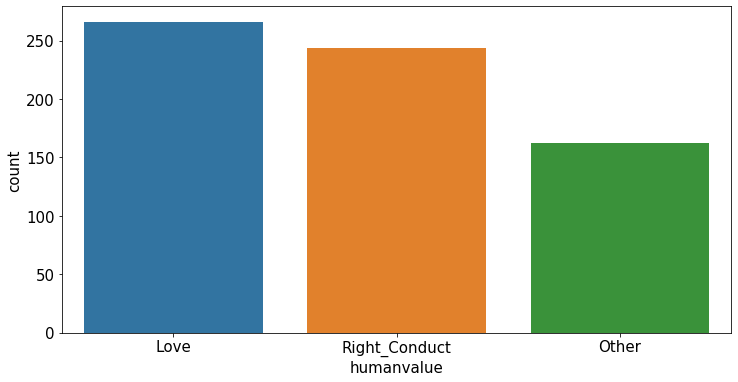

In [3]:
# Clean the data
discoursesingle.groupby('text').describe() # decribe data

# Observe Size
category_count = pandas.DataFrame()
category_count['count'] = discoursesingle['humanvalue'].value_counts()
fig, ax = plt.subplots(figsize = (12, 6))
seaborn.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('humanvalue',fontsize = 15)
ax.tick_params(labelsize=15)


def clean_data(sentence):
    ## removing web links
    s = [ re.sub(r'http\S+', '', sentence.lower())]
    ## removing words like gooood and poooor to good and poor
    s = [''.join(''.join(s)[:2] for _, s in itertools.groupby(s[0]))]
    ## removing appostophes
    s = [remove_appostophes(s[0])]
    ## removing punctuations from the code 
    s = [remove_punctuations(s[0])]
    return s[0]

def remove_punctuations(my_str):
    punctuations = '''!()-[]{};:'"\,./?@#$%^&@*_~'''
    no_punct = ""
    for char in my_str:
       if char not in punctuations:
           no_punct = no_punct + char
    return no_punct

def remove_appostophes(sentence):
    APPOSTOPHES = {"s" : "is", "re" : "are", "t": "not", "ll":"will","d":"had","ve":"have","m": "am"}
    words = nltk.tokenize.word_tokenize(sentence)
    final_words=[]
    for word in words:
        broken_words=word.split("'")
        for single_words in broken_words:
            final_words.append(single_words)
    reformed = [APPOSTOPHES[word] if word in APPOSTOPHES else word for word in final_words]
    reformed = " ".join(reformed)
    return reformed

## Sample Sentence to be cleaned
sentence="('Ahimso paramo dharmaha!' Nonvoilence is the best practice,')"
 
## Using clean_data function
clean_data(sentence)

# The clean data is working as expected, now let us clean corpus data

# Remove blank rows if any.
discoursesingle['text'].dropna(inplace=True)
discoursemultiple['text'].dropna(inplace=True)

# Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
discoursesingle['text'] = [entry.lower() for entry in discoursesingle['text']]
discoursemultiple['text'] = [entry.lower() for entry in discoursemultiple['text']]

for index in range(0,len(discoursesingle["text"])):
    discoursesingle.loc[index,"text"] = clean_data(discoursesingle["text"].iloc[index])
    
for index in range(0,len(discoursemultiple["text"])):
    discoursemultiple.loc[index,"text"] = clean_data(discoursemultiple["text"].iloc[index])

discoursesingle.head() # Data looks cleaned

In [4]:
## Converting the read dataset in to a list of tuples, each tuple(row) contianing the message and it's label#data_set = []
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

data_set = []
for index,row in discoursesingle.iterrows():
    data_set.append((row['text'], row['label'],row['humanvalue']))

#change to lower case, Tokenize and removes stopwords
def preprocess(document):
    #changes document to lower case, removes stopwords and lemmatizes/stems the remainder of the sentence'

    # change sentence to lower case
    document = document.lower()
    
    # tokenize into words
    words = word_tokenize(document)
    
    # remove stop words and words less than 3 characters
    words = [word for word in words if word not in stopwords.words("english") and re.sub(r'\b\w{1,3}\b', '', word)]
    
    # replace sanskrit words represented in English to English words
    #replace Prema to Love ; Dharma to righteousness ; sathya to truth ; Shanthi / Santhi / Shanti to peace; Ahimsa to Nonviolence  
    words = [word.replace("prema","love") for word in words]
    words = [word.replace("dharma","righteousness") for word in words]
    words = [word.replace("dharmo","righteousness") for word in words]
    words = [word.replace("sathya","truth") for word in words]
    words = [word.replace("shanthi","peace") for word in words]
    words = [word.replace("santhi","peace") for word in words]
    words = [word.replace("shanti","peace") for word in words]
    words = [word.replace("ahimsa","nonviolence") for word in words]
    words = [stemmer.stem(word) for word in words]
    #words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    
    # join words to make sentence
    document = " ".join(words)

    return document

## - Performing the preprocessing steps on all messages with length >= 3
wordtokenized = []
for (discourse, label,humanvalue) in data_set:
    words_filtered = [e.lower() for e in preprocess(discourse).split() if len(e) >= 3]
    wordtokenized.append((words_filtered, label,humanvalue))   

print(wordtokenized[:5])
#token_freq=nltk.FreqDist(word_tokenize)

[(['poison', 'word', 'anyon', 'word', 'wound', 'fatal', 'even', 'arrow'], 2, 'Love'), (['educ', 'charact'], 1, 'Right_Conduct'), (['worldli', 'thought', 'diminish', 'thought', 'increas', 'normal', 'mind', 'time', 'desir', 'worldli', 'thing', 'desir', 'peac', 'becom', 'stronger'], 0, 'Other'), (['cast', 'cast', 'human', 'religion', 'religion', 'love', 'languag', 'languag', 'heart'], 0, 'Other'), (['love', 'barren', 'cloud', 'moistur', 'tree', 'fruit', 'yield', 'milk', 'ever', 'never', 'earn', 'grace'], 2, 'Love')]


In [5]:
print(wordtokenized)

[(['poison', 'word', 'anyon', 'word', 'wound', 'fatal', 'even', 'arrow'], 2, 'Love'), (['educ', 'charact'], 1, 'Right_Conduct'), (['worldli', 'thought', 'diminish', 'thought', 'increas', 'normal', 'mind', 'time', 'desir', 'worldli', 'thing', 'desir', 'peac', 'becom', 'stronger'], 0, 'Other'), (['cast', 'cast', 'human', 'religion', 'religion', 'love', 'languag', 'languag', 'heart'], 0, 'Other'), (['love', 'barren', 'cloud', 'moistur', 'tree', 'fruit', 'yield', 'milk', 'ever', 'never', 'earn', 'grace'], 2, 'Love'), (['anger', 'jealousi', 'biggest', 'diseas', 'keep', 'aloof', 'three', 'diseas'], 2, 'Love'), (['life', 'mosaic', 'pleasur', 'pain', 'grief', 'interv', 'moment'], 1, 'Right_Conduct'), (['surrend', 'mind', 'complet', 'take', 'care', 'everi'], 0, 'Other'), (['love', 'bridg', 'chang', 'build', 'hous'], 1, 'Right_Conduct'), (['chariti', 'mean', 'land', 'full', 'beggar', 'provid', 'support', 'mean', 'beggar', 'provid', 'food', 'cloth', 'conveni', 'encourag', 'lazi', 'beg'], 2, 'Love

In [6]:
trainDF = pandas.DataFrame()
trainDF['text'] = discoursesingle['text']
trainDF['label'] = discoursesingle['label']
print(trainDF.head())

# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)


                                                text label
1  do not use poisonous words against anyone  for...     2
2                  the end of education is character     1
3  as worldly thoughts diminish  thoughts of god ...     0
4  there is only one caste  the caste of humanity...     0
5  a man who has no love in him is as barren as a...     2


## Feature Engineering

### Count Vectors as features

In [29]:
print(train_x)

560    today  wherever you look you will find hatred ...
435    therefore  you must have unity to attain divin...
100    in this chapter  swami enumerates the differen...
48     true devotion must not get dispirited  nor ela...
343    do not become a buffalo  in order to put you o...
406    it is love that gives rise to these two princi...
610    by consulting your conscience  whenever you ac...
33      being a good example is the best form of service
13            love is selflessness  self is lovelessness
309                  where there is faith there is love 
203                                  love with intensity
504                     love as a feeling is nonviolence
430    think what is good  see what is good  hear wha...
342    that is the principle of love  worldly love ma...
150    there can not be life without love  a small ex...
288    where is shanthi  peace   is it outside  no  i...
16     i am you  you are me  you are the waves  i am ...
487              self is fullne

In [7]:
# create a count vectorizer object - Bag of Words
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

### TF-IDF Vectors as features

In [8]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

### Word Embeddings

In [9]:
#from gensim.models import KeyedVectors
#from gensim.models.word2vec import Word2Vec
#from gensim.test.utils import common_texts, get_tmpfile
#path = get_tmpfile("word2vec.model")
#model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
#model.save("word2vec.model")

In [72]:
# load the pre-trained word-embedding vectors 

#Pending

### Text / NLP based features

In [10]:
trainDF['char_count'] = trainDF['text'].apply(len)
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [11]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))
trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))
trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

### Topic Models as features

In [12]:
#train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [13]:
print(topic_summaries)

['satwic stomach light sarvatāḥ permeates sit universe rajasic shiromukhaṃ sarvamāvrutya', 'weapons india needs manufacturing uphold countries asked money unshakable lovelessness', 'enlightened awaken truths seeks realize existence universal must an who', 'you and deed every kingdom whether values word practised friend', 'obtaining acceptable cheese little butter milk harm done them because', 'applied bala nearness friend loves quit lover brothers trivial discovery', 'the is you to of and in not it be', 'is power destroys knowledge that love character some evil but', 'facts unchanging tests ensures confidence ritham appearances seers momentary stain', 'guru stands elements faiths element another formless ru attributeless gu', 'showering abide profess religion a separate those to by faith', 'from detachment delusion steadiness leads to mind company freedom of', 'depends satwic valuable agitation blowing use possible doll likes wear', 'and are of the in to food animals we this', 'place c

### Model Building

In [34]:
# Utility function to train models

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

### Naive Bayes

In [35]:
#Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.47928994082840237
NB, WordLevel TF-IDF:  0.5207100591715976
NB, N-Gram Vectors:  0.5029585798816568
NB, CharLevel Vectors:  0.514792899408284


### Logistic Regression - Linear Classifier

In [36]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

LR, Count Vectors:  0.4260355029585799
LR, WordLevel TF-IDF:  0.5325443786982249
LR, N-Gram Vectors:  0.46153846153846156
LR, CharLevel Vectors:  0.5029585798816568


C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### SVM Model

In [42]:
accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
print ("Count Vectors: ", accuracy)

accuracy = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
print ("CharLevel Vectors: ", accuracy)

accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, WordLevel TF-IDF:  0.4437869822485207
Count Vectors:  0.4378698224852071
SVM, N-Gram Vectors:  0.4437869822485207


### Bagging Model

In [38]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  0.39644970414201186
RF, WordLevel TF-IDF:  0.39644970414201186


C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Xtereme Gradient Boosting Model

In [39]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  0.46745562130177515
Xgb, WordLevel TF-IDF:  0.5207100591715976
Xgb, CharLevel Vectors:  0.48520710059171596


### Shallow Neural Networks

In [40]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])

accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)

print ("NN, Ngram Level TF IDF Vectors",  accuracy)

Epoch 1/1
505/505 [==============================] - 1s 1ms/step - loss: 0.6415
NN, Ngram Level TF IDF Vectors 0.22485207100591717
